In [ ]:
# ── Imports & Reproducibility ────────────────────────────────────────────────
import os, copy
import csv                                                  # For result logging :contentReference[oaicite:0]{index=0}
import random                                               # For seeding :contentReference[oaicite:1]{index=1}
import numpy as np                                          # For numeric ops :contentReference[oaicite:2]{index=2}
import torch                                               # Core PyTorch :contentReference[oaicite:3]{index=3}
import torch.nn as nn                                       # Neural-net modules :contentReference[oaicite:4]{index=4}
import torch.nn.functional as F                             # Functional API :contentReference[oaicite:5]{index=5}
import torch.optim as optim                                 # Optimizers :contentReference[oaicite:6]{index=6}
from torch.optim.lr_scheduler import CosineAnnealingLR      # Scheduler :contentReference[oaicite:7]{index=7}
from torch.utils.data import DataLoader, random_split       # Data loaders & splits :contentReference[oaicite:8]{index=8}
import torchvision                                          # Datasets & transforms :contentReference[oaicite:9]{index=9}
import torchvision.transforms as T                          # Transforms :contentReference[oaicite:10]{index=10}
from torch.utils.tensorboard import SummaryWriter           # TensorBoard logging :contentReference[oaicite:11]{index=11}
import matplotlib.pyplot as plt                             # Plotting :contentReference[oaicite:12]{index=12}

In [ ]:
# Seed everything for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


# ── Device ───────────────────────────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")                             # Confirm GPU vs CPU :contentReference[oaicite:13]{index=13}



# ── Data Preparation ─────────────────────────────────────────────────────────
# Transforms
transform_train = T.Compose([
    T.RandomCrop(32, padding=4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])


Using device: cuda


In [ ]:
# ----- Checkpoints Utilities --------
import glob, torch, os

def latest_ckpt(dirpath, pattern=None):
    """
    If you pass pattern=None, we'll look for anything matching
    *_last_ckpt_round_*.pth and return the numerically latest file.
    """
    if pattern is None:
        pattern = "*_last_ckpt_round_*.pth"
    paths = glob.glob(os.path.join(dirpath, pattern))
    if not paths:
        return None
    # Extract the round number from each filename, assuming it ends in _<round>.pth
    def round_num(p):
        base = os.path.basename(p)
        # splits on underscores: shard_J{J}_last_ckpt_round_{rnd}.pth
        return int(base.rsplit("_",1)[1].split(".")[0])
    paths.sort(key=round_num)
    return paths[-1]


def load_checkpoint(model, optimizer, ckpt_dir, shard_key, J, resume=True):
    if not resume:
        return 1
    pat = f"Nc_entropy_JS_alpha_1_last_ckpt_round_*.pth"
    ckpt_path = latest_ckpt(ckpt_dir, pat)
    if ckpt_path is None:
        return 1
    ckpt = torch.load(ckpt_path, map_location='cpu')
    model.load_state_dict(ckpt['model_state'])
    optimizer.load_state_dict(ckpt['optimizer_state'])
    rng_state = ckpt['rng_state']
    if rng_state.device.type != 'cpu':
        rng_state = rng_state.cpu()
    torch.set_rng_state(rng_state)
    return ckpt['round'] + 1



def save_checkpoint(model, optimizer, round_num, ckpt_dir,
                    shard_key, J, is_best=False):
    """
    Saves:
      <shard_key>_J<J>_last_ckpt_round_<round_num>.pth
    and if is_best=True, also
      <shard_key>_J<J>_best_ckpt.pth
    """
    prefix = "Nc_entropy_JS_alpha_1"
    state = {
        'round': round_num,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict(),
        'rng_state': torch.get_rng_state(),
    }
    # unique filename per config
    last_name = f"{prefix}_last_ckpt_round_{round_num}.pth"
    torch.save(state, os.path.join(ckpt_dir, last_name))
    if is_best:
        best_name = f"{prefix}_best_ckpt.pth"
        torch.save(model.state_dict(), os.path.join(ckpt_dir, best_name))
    print(f"[Checkpoint] Saved {last_name}")


In [ ]:
# ── Data Preparation ─────────────────────────────────────────────────────────

# Download full CIFAR‑100 training set
full_train = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=True, transform=transform_train
)

# Centralized validation split
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)

# ── Build validation loader ───────────────────────────────
BS_VAL = 256
val_loader = DataLoader(
    val_dataset,
    batch_size=BS_VAL,
    shuffle=False,
    num_workers=2
)

# Ensure test_loader exists (fix NameError from summarize_run)
if 'test_loader' not in globals():
    print("Defining test_loader (was missing).")
    # require transform_test and BS_VAL to be defined
    if 'transform_test' not in globals():
        # fallback: define a default transform (shouldn't happen if you defined it earlier)
        transform_test = T.Compose([
            T.ToTensor(),
            T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
        ])
    test_dataset = torchvision.datasets.CIFAR100(
        './data', train=False, download=True, transform=transform_test
    )
    test_loader = DataLoader(test_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)
else:
    print("test_loader already defined in scope.")

# ── Non-IID Sharding Helper ────────────────────────────────────────────────

from collections import defaultdict, deque
from torch.utils.data import Subset

def create_labelwise_shards(dataset, K, Nc, seed=42):
    # Group indices by label
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)

    # Shuffle each label’s pool
    rng = random.Random(seed)
    for lbl in label2idx:
        rng.shuffle(label2idx[lbl])

    # Prepare an iterator per label
    pointers = {lbl: 0 for lbl in label2idx}

    # Build shards
    samples_per_client = len(dataset) // K
    shards_idx = []
    labels_cycle = list(label2idx.keys())

    for client_id in range(K):
        client_idxs = []
        # Rotate start point so clients don’t always pick the same first label
        rng.shuffle(labels_cycle)
        for lbl in labels_cycle:
            if len(client_idxs) >= samples_per_client:
                break
            # How many to take from this label
            needed = samples_per_client - len(client_idxs)
            available = len(label2idx[lbl]) - pointers[lbl]
            take = min(needed, available)
            if take > 0:
                start = pointers[lbl]
                end   = start + take
                client_idxs.extend(label2idx[lbl][start:end])
                pointers[lbl] += take
        # If we still haven’t reached samples_per_client (rare), fill randomly
        if len(client_idxs) < samples_per_client:
            all_remaining = [i for lbl in label2idx
                                 for i in label2idx[lbl][pointers[lbl]:]]
            client_idxs.extend(rng.sample(all_remaining,
                                          samples_per_client - len(client_idxs)))
        shards_idx.append(client_idxs)

    return [Subset(dataset, idxs) for idxs in shards_idx]


#NEW OUR CONTRIBUTION

# ── New: Non-IID shards with a random number of classes per client ─────────
from collections import defaultdict
from torch.utils.data import Subset

def create_labelwise_shards_sampled(dataset, K,
                                    min_classes=1, max_classes=50,
                                    sampler='uniform', poisson_lambda=5,
                                    allocation='equal', dirichlet_alpha=1.0,
                                    seed=42):
    """
    Build K disjoint subsets where each client:
      - samples n_classes ~ (uniform[min,max] OR 1+Poisson(lambda))
      - selects those classes (without replacement)
      - receives `target` examples distributed among the chosen classes
        according to `allocation` (equal or dirichlet proportions)
    Guarantees: no example is duplicated across clients and every example assigned.

    Args:
      dataset: torch Dataset (train_dataset)
      K: number of clients
      min_classes, max_classes: bounds for sampled number of classes per client
      sampler: 'uniform' or 'poisson'
      poisson_lambda: lambda for Poisson sampler
      allocation: 'equal' | 'dirichlet' | 'random' (random proportional)
      dirichlet_alpha: alpha parameter for Dirichlet (if allocation == 'dirichlet')
      seed: RNG seed for reproducibility

    Returns:
      list_of_subsets: list of torch.utils.data.Subset objects length K
    """
    # --- Build per-label index pools (deques for efficient popleft) ---
    label2idx = defaultdict(list)
    for idx, (_, lbl) in enumerate(dataset):
        label2idx[lbl].append(idx)
    # shuffle each label's pool reproducibly
    rng_py = random.Random(seed)
    for lbl in label2idx:
        rng_py.shuffle(label2idx[lbl])
    label_deques = {lbl: deque(label2idx[lbl]) for lbl in label2idx}
    labels = list(label_deques.keys())
    n_labels_total = len(labels)

    # --- compute per-client target sizes (balanced remainder) ---
    N = len(dataset)
    base = N // K
    remainder = N % K
    target_sizes = [base + (1 if i < remainder else 0) for i in range(K)]

    # helper: sample number of classes
    def sample_n_classes_local():
        if sampler == 'uniform':
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))
        elif sampler == 'poisson':
            # use numpy's generator seeded with rng_py for reproducibility
            seed_local = rng_py.randint(0, 2**31 - 1)
            n = int(np.random.default_rng(seed_local).poisson(lam=poisson_lambda)) + 1
            return max(min_classes, min(n, min(max_classes, n_labels_total)))
        else:
            return rng_py.randint(min_classes, min(max_classes, n_labels_total))

    # helper: allocate counts across chosen classes given target and allocation scheme
    def allocate_counts(target, n_chosen):
        if n_chosen <= 0:
            return []
        if allocation == 'equal':
            base_share = target // n_chosen
            rem = target % n_chosen
            alloc = [base_share + (1 if i < rem else 0) for i in range(n_chosen)]
            return alloc
        elif allocation == 'dirichlet':
            # sample proportions from Dirichlet(alpha)
            alpha = np.ones(n_chosen) * float(dirichlet_alpha)
            prop = np.random.default_rng(rng_py.randint(0, 2**31-1)).dirichlet(alpha)
            raw = prop * target
            # convert to integer allocation preserving sum==target
            floored = np.floor(raw).astype(int).tolist()
            leftover = target - sum(floored)
            # distribute leftover to largest fractional parts
            fracs = raw - np.floor(raw)
            order = np.argsort(fracs)[::-1]
            for j in range(leftover):
                floored[order[j]] += 1
            return floored
        else:  # 'random' : choose random integer splits (via multinomial)
            rng_seed = rng_py.randint(0, 2**31 - 1)
            props = np.random.default_rng(rng_seed).multinomial(target, [1.0 / n_chosen] * n_chosen)
            return props.tolist()

    # Prepare result list and a randomized client order to mitigate ordering bias
    client_indices = [[] for _ in range(K)]
    client_order = list(range(K))
    rng_py.shuffle(client_order)  # process clients in random order (deterministic from seed)

    # For speed: keep a small lookup of remaining counts per label
    remaining_per_label = {lbl: len(label_deques[lbl]) for lbl in labels}

    for client_id in client_order:
        target = target_sizes[client_id]
        # sample how many classes this client *wants*
        n_classes = sample_n_classes_local()
        n_classes = min(n_classes, n_labels_total)  # safety

        # choose the classes for this client (without replacement)
        # but prefer classes that still have remaining samples: sample from labels weighted by availability
        available_labels = [lbl for lbl in labels if remaining_per_label.get(lbl, 0) > 0]
        if len(available_labels) == 0:
            # no remaining samples anywhere — extremely unlikely
            break

        # If available_labels < n_classes, we will only choose those available; rest will be filled later.
        if len(available_labels) <= n_classes:
            chosen_labels = available_labels[:]
            rng_py.shuffle(chosen_labels)
        else:
            # sample without replacement among available labels
            # use rng_py.sample for reproducibility
            chosen_labels = rng_py.sample(available_labels, k=n_classes)

        # compute desired allocation across chosen_labels
        alloc = allocate_counts(target, len(chosen_labels))

        # Try to fulfill allocation from chosen labels, consuming their deques
        client_taken = []
        shortfall = 0
        for lbl, want in zip(chosen_labels, alloc):
            available = remaining_per_label.get(lbl, 0)
            take = min(want, available)
            for _ in range(take):
                client_taken.append(label_deques[lbl].popleft())
            remaining_per_label[lbl] = remaining_per_label.get(lbl, 0) - take
            if take < want:
                shortfall += (want - take)

        # If there is a shortfall, try to fill it from other labels (scan labels by remaining)
        if shortfall > 0:
            # build a list of labels sorted by remaining count (descending) to fill quickly
            refill_labels = sorted(labels, key=lambda x: remaining_per_label.get(x, 0), reverse=True)
            for lbl in refill_labels:
                if shortfall <= 0:
                    break
                available = remaining_per_label.get(lbl, 0)
                if available <= 0:
                    continue
                take = min(available, shortfall)
                for _ in range(take):
                    client_taken.append(label_deques[lbl].popleft())
                remaining_per_label[lbl] -= take
                shortfall -= take

        # Final safety: if still short (very unlikely), allow sampling from any remaining indices with replacement
        if len(client_taken) < target:
            need = target - len(client_taken)
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) >= need and len(all_remaining) > 0:
                # take deterministically from the front of remaining pools
                # and advance pointers (pop left)
                taken_now = all_remaining[:need]
                # Pop these indices from deques by label
                taken_count = 0
                for lbl in labels:
                    while taken_count < need and len(label_deques[lbl]) > 0:
                        client_taken.append(label_deques[lbl].popleft())
                        remaining_per_label[lbl] -= 1
                        taken_count += 1
                        if taken_count >= need:
                            break
            else:
                # fallback: sample with replacement from full index range (shouldn't be necessary)
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        # Ensure exact target
        if len(client_taken) > target:
            client_taken = client_taken[:target]
        elif len(client_taken) < target:
            # pad (should not happen) with random indices not yet used if possible
            all_remaining = []
            for lbl in labels:
                all_remaining.extend(list(label_deques[lbl]))
            if len(all_remaining) > 0:
                client_taken += all_remaining[:(target - len(client_taken))]
                # pop them
                taken_rem = target - len(client_taken)
                popped = 0
                for lbl in labels:
                    while popped < taken_rem and len(label_deques[lbl]) > 0:
                        label_deques[lbl].popleft()
                        remaining_per_label[lbl] -= 1
                        popped += 1
                        if popped >= taken_rem:
                            break
            else:
                # absolute last resort: sample from full dataset with replacement
                rng2 = random.Random(rng_py.randint(0, 2**31 - 1))
                while len(client_taken) < target:
                    client_taken.append(rng2.choice(range(N)))

        client_indices[client_id] = client_taken

    # Final check: every example should be assigned exactly once
    all_assigned = [i for lst in client_indices for i in lst]
    if len(all_assigned) != len(set(all_assigned)):
        # Debug info if something went wrong
        dup_count = len(all_assigned) - len(set(all_assigned))
        print(f"[Warning] {dup_count} duplicates detected in assignment (unexpected).")
    if sum(len(lst) for lst in client_indices) != N:
        # Some items may remain unassigned if remainder was mis-handled; append them to last clients
        remaining = []
        for lbl in labels:
            remaining.extend(list(label_deques[lbl]))
        if remaining:
            # distribute remaining to clients with available capacity
            for idx in remaining:
                # find first client with room
                for cid in range(K):
                    if len(client_indices[cid]) < target_sizes[cid]:
                        client_indices[cid].append(idx)
                        break

    # Convert to Subsets
    subsets = [Subset(dataset, idxs) for idxs in client_indices]
    return subsets

# ── Utility: number of unique classes in a Subset ─────────────────────────────────
def subset_num_classes(subset):
    labs = set()
    # subset is a torch.utils.data.Subset pointing to original dataset
    base_ds = subset.dataset
    for idx in subset.indices:
        _, lbl = base_ds[idx]
        labs.add(lbl)
    return len(labs)


100%|██████████| 169M/169M [00:23<00:00, 7.18MB/s]


Defining test_loader (was missing).


In [ ]:
# ---- Compute labelwise shards ----
K = 100
base = train_size // K
sizes = [base] * (K - 1) + [train_size - base * (K - 1)]
##iid_shards = random_split(train_dataset, sizes, generator=torch.Generator().manual_seed(seed))

##shardings = {'iid': iid_shards}
shardings = {}

# Add old non_iid_Nc variants if you want to keep them
Nc_list = [1, 5, 10, 50]
"""for Nc in Nc_list:
    shardings[f'non_iid_{Nc}'] = create_labelwise_shards(train_dataset, K, Nc, seed)"""

# Add new random-classes variants:
shardings['sampled_uniform'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=50,
    sampler='uniform', allocation='equal', seed=42
)
print(f'sharding keys after sampled_uniform: {shardings.keys()}')

sharding keys after sampled_uniform: dict_keys(['sampled_uniform'])


In [ ]:

subsets = shardings['sampled_uniform']
K_check = len(subsets)
samples_per_client = len(subsets[0].indices)

# same size per client
sizes = [len(s.indices) for s in subsets]
print("sizes: min, max, unique counts:", min(sizes), max(sizes), set(sizes))

# no duplicates across clients and coverage
all_idxs = [i for s in subsets for i in s.indices]
total_assigned = len(all_idxs)
unique_assigned = len(set(all_idxs))
print("total_assigned:", total_assigned, "unique_assigned:", unique_assigned)

if unique_assigned != total_assigned:
    print("WARNING: some indices are duplicated across clients.")
else:
    print("OK: no duplicated indices across clients.")

# full coverage (only true if K * samples_per_client == len(dataset))
N = len(train_dataset)
print("dataset size N:", N, "K*samples_per_client:", K_check * samples_per_client)
if K_check * samples_per_client == N:
    print("OK: every example is assigned exactly once.")
else:
    print("Note: not all examples were assigned (this is expected if N not divisible by K).")

# classes per client distribution
def subset_num_classes(sub):
    base = sub.dataset
    labs = set(base[idx][1] for idx in sub.indices)
    return len(labs)

classes_per_client = [subset_num_classes(s) for s in subsets]
print("classes per client: min, max, mean:", min(classes_per_client), max(classes_per_client), sum(classes_per_client)/len(classes_per_client))


sizes: min, max, unique counts: 450 450 {450}
total_assigned: 45000 unique_assigned: 45000
OK: no duplicated indices across clients.
dataset size N: 45000 K*samples_per_client: 45000
OK: every example is assigned exactly once.
classes per client: min, max, mean: 2 49 24.38


Saved classes_per_client.csv (client_id, unique_classes)


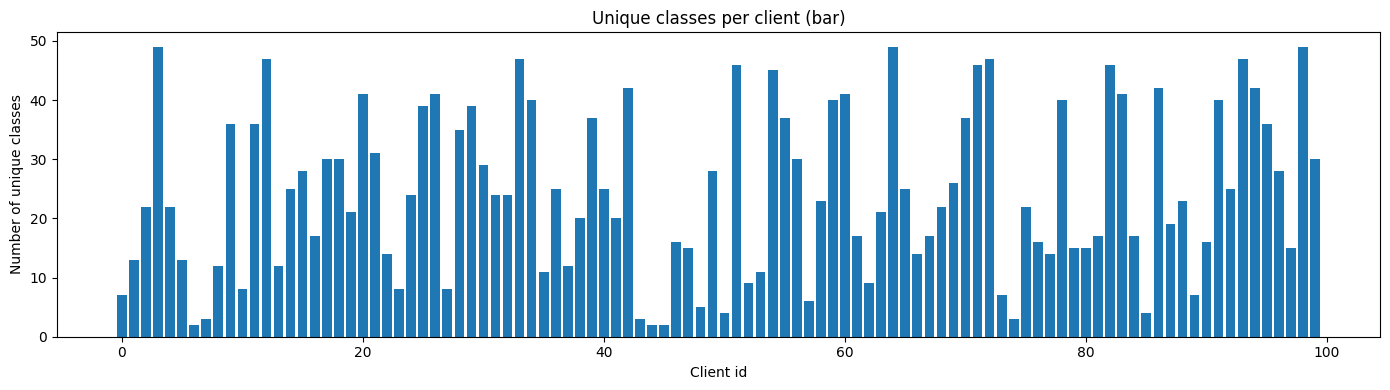

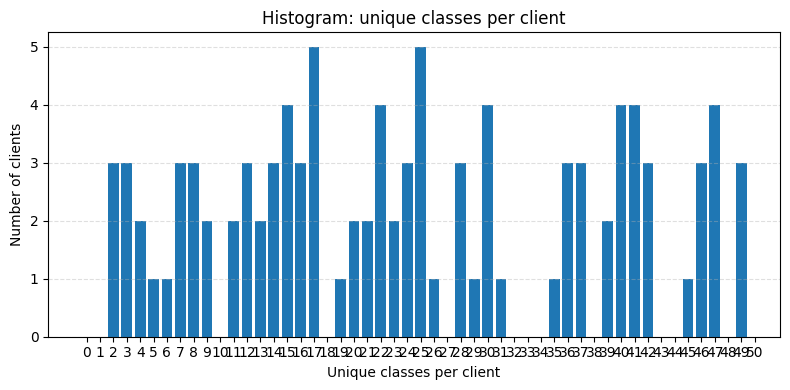

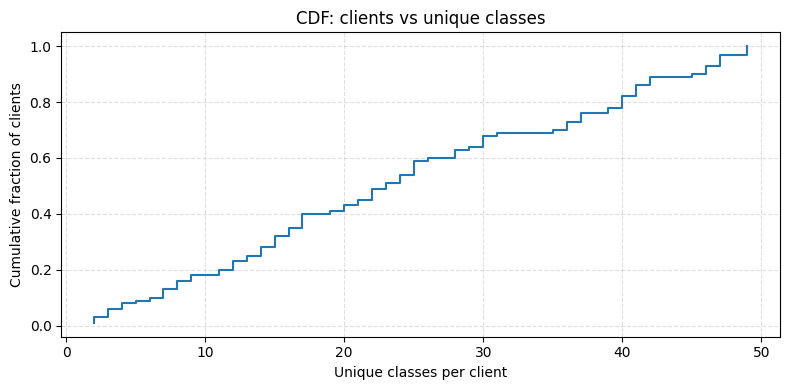

min, max, mean, median, std: 2 49 24.38 23.0 13.898762534844606

Top 10 clients by number of unique classes:
  client_id  unique_classes
         3              49
        64              49
        98              49
        12              47
        93              47
        72              47
        33              47
        71              46
        51              46
        82              46


In [ ]:
# Helper: compute unique classes per subset (client)
import pandas as pd

def subset_num_classes(subset, dataset):
    labs = set(dataset[idx][1] for idx in subset.indices)
    return len(labs)

# Compute
K = len(subsets)
classes_per_client = [subset_num_classes(s, train_dataset) for s in subsets]

# DataFrame for convenience
df = pd.DataFrame({
    'client_id': np.arange(K),
    'unique_classes': classes_per_client
})
df.to_csv("classes_per_client.csv", index=False)
print("Saved classes_per_client.csv (client_id, unique_classes)")

# Bar plot (clients on x)
plt.figure(figsize=(14,4))
plt.bar(df['client_id'], df['unique_classes'])
plt.xlabel("Client id")
plt.ylabel("Number of unique classes")
plt.title("Unique classes per client (bar)")
plt.tight_layout()
plt.savefig("classes_per_client_bar.png")
plt.show()

# Histogram (distribution)
max_classes = max(classes_per_client)
bins = range(0, max_classes+2)  # integer bins
plt.figure(figsize=(8,4))
plt.hist(classes_per_client, bins=bins, align='left', rwidth=0.8)
plt.xticks(bins)
plt.xlabel("Unique classes per client")
plt.ylabel("Number of clients")
plt.title("Histogram: unique classes per client")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("classes_per_client_hist.png")
plt.show()

# CDF (cumulative distribution)
vals_sorted = np.sort(classes_per_client)
cdf = np.arange(1, K+1) / K
plt.figure(figsize=(8,4))
plt.step(vals_sorted, cdf, where='post')
plt.xlabel("Unique classes per client")
plt.ylabel("Cumulative fraction of clients")
plt.title("CDF: clients vs unique classes")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("classes_per_client_cdf.png")
plt.show()

# Quick stats
print("min, max, mean, median, std:", np.min(classes_per_client),
      np.max(classes_per_client), np.mean(classes_per_client),
      np.median(classes_per_client), np.std(classes_per_client))

# Optional: top clients with most classes
top = df.sort_values('unique_classes', ascending=False).head(10)
print("\nTop 10 clients by number of unique classes:\n", top.to_string(index=False))

In [ ]:
# === Diversity utilities (Nc + entropy + JS divergence) ===
from collections import Counter
from scipy.spatial.distance import jensenshannon
import numpy as np
import math

NUM_CLASSES = 100  # number of classes in CIFAR-100

def client_class_histograms(shards, dataset, num_classes=NUM_CLASSES):
    """
    Returns a (K, C) numpy array where each row is the histogram of class counts
    for one client: K clients, C classes.
    """
    hists = []
    for sub in shards:
        # Collect labels by indexing the original dataset (dataset[idx][1] yields label)
        labels = [dataset[idx][1] for idx in sub.indices]
        # Count occurrences per class
        cnt = Counter(labels)
        # Initialize zero histogram of length C
        hist = np.zeros(num_classes, dtype=np.int64)
        # Fill histogram with counts for classes present in this subset
        for c, n in cnt.items():
            hist[c] = n
        hists.append(hist)
    # stack into shape (K, C)
    return np.stack(hists, axis=0)


def entropy_from_hist(hist):
    """
    Compute the Shannon entropy of the class distribution represented by `hist`.
    H = - sum_k p_k * log(p_k), where p_k = hist[k] / sum(hist).
    Uses natural logarithm (base e). Returns 0.0 if the histogram is empty.
    """
    n = hist.sum()
    if n == 0:
        # no samples => define entropy as 0
        return 0.0
    # normalized class probabilities
    p = hist / n
    # keep only positive probabilities to avoid log(0)
    p = p[p > 0]
    # compute and return entropy using the natural log (float)
    return float(-np.sum(p * np.log(p)))

# ---- Jensen-Shannon divergence ----

def js_distance_matrix(hists):
    """Compute pairwise JS divergence matrix on normalized histograms"""
    rows = hists.sum(axis=1, keepdims=True)
    rows[rows==0] = 1.0
    P = hists / rows
    K = P.shape[0]
    D = np.zeros((K, K))
    for i in range(K):
        for j in range(i+1, K):
            d = jensenshannon(P[i], P[j])
            D[i,j] = D[j,i] = d
    return D


def diversity_scores_from_hists(hists, lam, alpha):
    """
    Compute per-client diversity scores by combining:
      - Structural diversity: number of unique classes present (Nc)
      - Distributional diversity: entropy of class distribution (H)

    Formula per client:
        D_i = lam * (Nc / C) + (1 - lam) * (H / log(C))

    where:
      - Nc  = number of distinct classes for client i (integer)
      - H   = entropy of the class distribution for client i (natural-log entropy)
      - C   = total number of classes (num columns in hists)
      - lam = weight in [0,1] balancing Nc vs entropy (lam=1 uses only Nc; lam=0 uses only entropy)

     To account for inter-client differences, we also compute the
    Jensen–Shannon (JS) divergence between clients and combine it with D_i:

        Final score = alpha * D_i + (1 - alpha) * JS_i

    where:
      - alpha     = mixing coefficient (0 = only JS, 1 = only D_i)
      - JS_i = mean JS divergence of client i from others


    Returns:
      scores_combined : numpy array shape (K,)  -- array of final diversity scores in [0,1]
      Nc     : numpy array shape (K,)  -- array, number of classes per client (int)
      Hs     : numpy array shape (K,)  -- array, entropy per client (float)
    """

    K, C = hists.shape

    # Count number of classes with at least one sample per client (array of number of classes)
    Nc = (hists > 0).sum(axis=1)

    # Compute entropy per client (array of entropies)
    Hs = np.array([entropy_from_hist(h) for h in hists], dtype=np.float64)

    # Normalize Nc and Hs to [0,1]-like ranges to get comparably scaled terms
    #   Nc/C  → fraction of possible classes present (in [0,1])
    #   Hs/log(C) → entropy scaled by maximum possible entropy (maximum entropy for C classes (uniform) is log(C))
    denom = np.log(C) if C > 1 else 1.0  # stability for C==1: protect division by log(C):
    scores = lam * (Nc / C) + (1 - lam) * (Hs / denom)

    # Calculate JS distance matrix
    D = js_distance_matrix(hists)   ## shape (K, K)

    # For each client, compute the average distance from all the others (js_scores is an array of mean distances)
    js_scores = D.mean(axis=1)      # (K,)

    # Normalize in [0, 1]
    js_scores = js_scores / js_scores.max()

    # Blend intra-client diversity and inter-client dissimilarity
    # alpha = 0  only JS_i, alpha = 1 only D_i, alpha = 0.5 D_i + JS
    scores_combined = alpha * scores + (1 - alpha) * js_scores

    # Return final scores, ensuring float64 precision
    return scores_combined.astype(np.float64), Nc, Hs

    # This score favors clients that either have many different classes (Nc large) or have balanced class distributions (H large), depending on lam
    # Normalization makes the two terms comparable despite different ranges/units


In [ ]:
# === Client Selection ===

from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial.distance import cdist

# ---- Weighted Selection (Nc + entropy + JS distance) ----
def sample_clients_by_diversity(D, m, rng, eps=1e-2):
    """
    Sample m clients (without replacement) from K clients using a probability
    distribution biased by diversity scores D.

    Args:
      D   : array-like shape (K,)   -- diversity scores per client
      m   : int                    -- number of clients to select in this round
      rng : numpy.random.Generator -- RNG used for reproducible sampling
      eps : float                  -- small positive floor added to weights to avoid zeros

    Returns:
      selected_indices : list of ints length m -- chosen client indices
      p                : ndarray shape (K,)     -- final probability vector summing to 1
    """
    import numpy as np

    # convert D to numpy array of floats and get K
    D = np.asarray(D, dtype=np.float64)
    K = D.shape[0]

    assert m <= K, "m must be <= K when sampling without replacement"

    # Normalize D into [0, 1] (small epsilon avoids division by zero if D is constant)
    Dn = (D - D.min()) / (D.max() - D.min() + 1e-12)

    # Use normalized D directly as weights (add epsilon floor)
    w_div = Dn + eps

    # Convert weights to a probability distribution
    p = w_div / w_div.sum()

    # Sample m clients without replacement according to final probabilities p
    selected = rng.choice(K, size=m, replace=False, p=p)

    return selected.tolist(), p

In [ ]:
# ── Model Definition ─────────────────────────────────────────────────────────
class LELeNetCIFAR(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1   = nn.Linear(64*8*8, 384)
        self.fc2   = nn.Linear(384, 192)
        self.fc3   = nn.Linear(192, 100)
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x)); x = F.relu(self.fc2(x))
        return self.fc3(x)

In [ ]:
# ── Utilities: Train/Eval & Checkpointing ────────────────────────────────────
def train_one_epoch(model, optimizer, criterion, loader):
    model.train()
    running_loss = correct = total = 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, lbls)
        loss.backward(); optimizer.step()
        running_loss += loss.item()*imgs.size(0)
        correct += out.argmax(1).eq(lbls).sum().item()
        total += lbls.size(0)
    return running_loss/total, correct/total

def eval_model(model, criterion, loader):
    model.eval()
    running_loss = correct = total = 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(device), lbls.to(device)
            out = model(imgs); loss = criterion(out, lbls)
            running_loss += loss.item()*imgs.size(0)
            correct += out.argmax(1).eq(lbls).sum().item()
            total += lbls.size(0)
    return running_loss/total, correct/total


def sample_clients_dirichlet(K, m, gamma, rng):
    """
    Sample m out of K client indices, with probabilities:
      • uniform if gamma == 'uniform'
      • drawn from Dirichlet([gamma]*K) otherwise.
    Returns:
      selected: list of m client indices
      p:        length-K numpy array of sampling probs (sums to 1)
    """
    if gamma == 'uniform':
        p = np.ones(K) / K
    else:
        alpha = np.ones(K) * gamma
        p     = rng.dirichlet(alpha)
    selected = rng.choice(K, size=m, replace=False, p=p)
    return selected.tolist(), p

In [ ]:
# ── Configuration Summary & Utilities for FedAvg ──────────────────────────────

import os, sys, platform, time
import torch
import numpy as np
import random
from torch.utils.tensorboard import SummaryWriter



# Hyperparameters
K, C = 100, 0.1
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 1000
budget   = J0 * R0
J_list   = [4, 8, 16]



# Define and instantiate TensorBoard writer
log_dir = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)

# Summary utility
def summarize_run(cfg, client_loaders, test_loader, writer=None):
    """
    Print and log summary for a FedAvg run.
    """
    ts = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
    print(f"\n========== FEDAVG RUN SUMMARY ({ts}) ==========")
    # Hyperparameters
    for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
        print(f"    • {key}: {cfg[key]}")
    # Data info
    num_clients  = len(client_loaders)
    shard_size   = len(client_loaders[0].dataset)
    test_samples = len(test_loader.dataset)
    print(f"    • clients (K): {num_clients}, shard size: {shard_size}")
    print(f"    • test samples: {test_samples}, batch size: {cfg['batch_size']}")
    # Log to TensorBoard
    if writer:
        for key in ['lr','weight_decay','batch_size','K','C','J','ROUNDS']:
            writer.add_text(f'RunInfo/{key}', str(cfg[key]), 0)

# Checkpoint utility
ckpt_dir = './checkpoints'
os.makedirs(ckpt_dir, exist_ok=True)


# ── Example Usage ────────────────────────────────────────────────────────────────

cfg = {
    'lr':           LR,
    'weight_decay': WD,
    'batch_size':   BS,
    'K':            K,
    'C':            C,
    'J0':            J0,
    'ROUNDS':       R0

}



In [ ]:

# ── A. Mount Google Drive ─────────────────────────────────────────────────────
from google.colab import drive
import os

drive.mount('/content/drive')
# Point to a folder inside your Drive for persistent checkpoints
CKPT_DIR = '/content/drive/MyDrive/Nc_entropy_JS_alpha_1/checkpoints'
os.makedirs(CKPT_DIR, exist_ok=True)




# Set this to True to resume from the last checkpoint; False to start from scratch
RESUME = True



# Hyperparameters
K, C = 100, 0.1
BS, BS_VAL = 128, 256
LR, WD = 0.01, 1e-4
J0, R0   = 4, 1000
budget   = J0 * R0
J = 4

# Transforms & Data
transform_train = T.Compose([
    T.RandomCrop(32, 4), T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])
transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5071,0.4867,0.4408),(0.2675,0.2565,0.2761)),
])

full_train = torchvision.datasets.CIFAR100(
    './data', train=True, download=True, transform=transform_train
)
val_size   = 5000
train_size = len(full_train) - val_size
train_dataset, val_dataset = random_split(
    full_train, [train_size, val_size],
    generator=torch.Generator().manual_seed(seed)
)
val_loader = DataLoader(val_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)

test_dataset = torchvision.datasets.CIFAR100(
    './data', train=False, download=True, transform=transform_test
)
test_loader = DataLoader(test_dataset, batch_size=BS_VAL, shuffle=False, num_workers=2)



# ── Instantiate TensorBoard writer ──────────────────────────────────────────────
from torch.utils.tensorboard import SummaryWriter
log_dir   = f"./logs/FedAvg_lr{LR}_wd{WD}_bs{BS}"
tb_writer = SummaryWriter(log_dir=log_dir)



# ── CSV Logging Setup ────────────────────────────────────────────────────────
import csv, os
#csv_path = './fedavg_results.csv'
csv_path = '/content/drive/MyDrive/Diversity_Score/Diversity_Score_fedavg_results.csv'
if not os.path.exists(csv_path):
    with open(csv_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([
            'name', 'round', 'round_time',
            'local_mean', 'local_std',
            'val_loss', 'val_acc',
            'test_loss', 'test_acc'
        ])


# Build all shardings
base = train_size // K
sizes = [base]*(K-1) + [train_size-base*(K-1)]
##iid_shards = random_split(train_dataset, sizes, generator=torch.Generator().manual_seed(seed))

Nc_list   = [1, 5, 10, 50]
##shardings = {'iid': iid_shards}
shardings = {}

"""for Nc in Nc_list:
    shardings[f'non_iid_{Nc}'] = create_labelwise_shards(
        train_dataset, K, Nc, seed
    )"""

# Add new random-classes variants:
shardings['sampled_uniform'] = create_labelwise_shards_sampled(
    train_dataset, K,
    min_classes=1, max_classes=50,
    sampler='uniform', allocation='equal', seed=42
)
print(f'sharding keys after sampled_uniform: {shardings.keys()}')

cfg = {'lr': LR, 'weight_decay': WD, 'batch_size': BS, 'K': K, 'C': C}

rng = np.random.default_rng(seed)


# ── FedAvg Training Loop ────────────────────────────────────────────────────────────
all_results = {}

"""for shard_key, shards in shardings.items():
    client_loaders = [
        DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
        for i in range(K)
    ]"""
print(f"sharding keys: {shardings.keys()}")
shard_keys_to_run = ['sampled_uniform']  # or ['non_iid_random_poisson_1_20'], or both

for shard_key in shard_keys_to_run:
    shards = shardings[shard_key]
    client_loaders = [
        DataLoader(shards[i], batch_size=BS, shuffle=True, num_workers=2)
        for i in range(K)
    ]

    # Compute class distribution (number of samples per class) for different clients
    hists = client_class_histograms(shards, train_dataset, num_classes=100)

    alpha_list = [0.1, 0.2, 0.5, 0.8, 1.0]

    for alpha in alpha_list:
        # Compute different measures of diversity from the histograms
        # D_scores: combined diversity score (a weighted mix of number of classes per client, entropy and JS divergence, with lam controlling the weight, alpha controlling the JS divergence)
        # D_Nc: number of distinct classes per client
        # D_H: entropy of the class distribution for each client
        D_scores, D_Nc, D_H = diversity_scores_from_hists(hists, lam=0.5, alpha=alpha)

        # Print summary statistics (min, mean, max) for each metric across clients
        print(f"[Diversity] Nc min/mean/max = {D_Nc.min()}/{D_Nc.mean():.2f}/{D_Nc.max()}")
        print(f"[Diversity] H  min/mean/max = {D_H.min():.2f}/{D_H.mean():.2f}/{D_H.max():.2f}")
        print(f"[Diversity] D  min/mean/max = {D_scores.min():.3f}/{D_scores.mean():.3f}/{D_scores.max():.3f}")

        ROUNDS_scaled = budget // J
        cfg.update({'J': J, 'ROUNDS': ROUNDS_scaled})
        summarize_run(cfg, client_loaders, test_loader, writer=tb_writer)

        # Initialize model & optimizer, then resume if any
        model     = LELeNetCIFAR().to(device)
        optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
        criterion = nn.CrossEntropyLoss()
        start_round = load_checkpoint(
            model, optimizer,
            ckpt_dir=CKPT_DIR,
            shard_key=shard_key, J=J,
            resume=RESUME
        )

        acc_hist = []
        print(f"[alpha = {alpha}] Starting from round {start_round}/{ROUNDS_scaled}")

        for rnd in range(start_round, ROUNDS_scaled + 1):
            m = max(1, int(C * K))
            #selected, _ = sample_clients_dirichlet(K, m, gamma='uniform', rng=rng)
            round_start = time.time()

            ## ---- DIVERSITY SCORE SELECTION ----
            selected, p = sample_clients_by_diversity(
                D_scores, m, rng=rng)

            # Local updates
            local_accuracies = []
            local_states, sizes = [], []
            for cid in selected:
                cm    = copy.deepcopy(model)
                opt_c = optim.SGD(cm.parameters(), lr=LR, momentum=0.9, weight_decay=WD)
                for _ in range(J):
                    train_loss, train_acc = train_one_epoch(cm, opt_c, criterion, client_loaders[cid])
                local_states.append(cm.state_dict())
                sizes.append(len(shards[cid]))
                local_accuracies.append(train_acc)


            # Compute local mean & std
            local_mean = np.mean(local_accuracies)
            local_std  = np.std(local_accuracies)

            # Aggregate
            total = sum(sizes)
            new_st = {
                k: sum((sizes[i] / total) * local_states[i][k] for i in range(len(sizes)))
                for k in model.state_dict()
            }
            model.load_state_dict(new_st)

            # Evaluation
            val_loss, val_acc   = eval_model(model, criterion, val_loader)
            acc_hist.append(val_acc)
            test_loss, test_acc = eval_model(model, criterion, test_loader)
            acc_hist.append(test_acc)

            # Timing
            round_time = time.time() - round_start

            # CSV Logging
            with open(csv_path, 'a', newline='') as f:
                csv.writer(f).writerow([
                    f"alpha = {alpha}", rnd,
                    f"{round_time:.2f}",
                    f"{local_mean:.4f}", f"{local_std:.4f}",
                    f"{val_loss:.4f}", f"{val_acc:.4f}",
                    f"{test_loss:.4f}", f"{test_acc:.4f}"
                ])

            # TensorBoard Logging
            tb_writer.add_scalar(f"alpha={alpha}_round_time", round_time, rnd)
            tb_writer.add_scalar(f"alpha={alpha}_local_acc_mean", local_mean, rnd)
            tb_writer.add_scalar(f"alpha={alpha}_local_acc_std",  local_std,  rnd)
            tb_writer.add_scalar(f"alpha={alpha}_val_loss",       val_loss,    rnd)
            tb_writer.add_scalar(f"alpha={alpha}_val_acc",        val_acc,     rnd)
            tb_writer.add_scalar(f"alpha={alpha}_test_loss",      test_loss,   rnd)
            tb_writer.add_scalar(f"alpha={alpha}_test_acc",       test_acc,    rnd)

            # Print per-round summary
            print(
                f"[alpha = {alpha}] Round {rnd}/{ROUNDS_scaled} "
                f"Time={round_time:.1f}s | "
                f"Local Acc={local_mean:.3f}±{local_std:.3f} | "
                f"Val Acc={val_acc:.3f} | Test Acc={test_acc:.3f}"
            )


            # Checkpoint every 20 rounds (or at first)
            if rnd == start_round or rnd % 20 == 0:
              # Log a header with the current config and round
              print(f"[{shard_key} | J={J}] Checkpointing at round {rnd}/{ROUNDS_scaled}")

              # Print the latest metrics
              print(f"    → Last Val Acc: {val_acc:.4f} | Last Val Loss: {val_loss:.4f}")
              print(f"    → Last Test Acc: {test_acc:.4f} | Last Test Loss: {test_loss:.4f}")

              # Save the checkpoint
              save_checkpoint(
                  model, optimizer,
                  round_num=rnd,
                  ckpt_dir=CKPT_DIR,
                  shard_key=shard_key, J=J,
                  is_best=False
              )
              print(f"[alpha = {alpha}] Checkpoint saved.\n")

        all_results[(shard_key, J)] = np.array(acc_hist)



Mounted at /content/drive
sharding keys after sampled_uniform: dict_keys(['sampled_uniform'])
sharding keys: dict_keys(['sampled_uniform'])
[Diversity] Nc min/mean/max = 2/24.38/49
[Diversity] H  min/mean/max = 0.64/2.93/3.89
[Diversity] D  min/mean/max = 0.080/0.440/0.667

========== FEDAVG RUN SUMMARY (2025-09-01 13:33:28) ==========
    • lr: 0.01
    • weight_decay: 0.0001
    • batch_size: 128
    • K: 100
    • C: 0.1
    • J: 4
    • ROUNDS: 1000
    • clients (K): 100, shard size: 450
    • test samples: 10000, batch size: 128
[sampled_uniform|J=4] Starting from round 1/1000
[Nc_entropy_JS_alpha_1 | J=4] Round 1/1000 Time=18.5s | Local Acc=0.047±0.022 | Val Acc=0.010 | Test Acc=0.010
[sampled_uniform | J=4] Checkpointing at round 1/1000
    → Last Val Acc: 0.0100 | Last Val Loss: 4.6055
    → Last Test Acc: 0.0102 | Last Test Loss: 4.6055
[Checkpoint] Saved Nc_entropy_JS_alpha_1_last_ckpt_round_1.pth
[Nc_entropy_JS_alpha_1 | J=4] Checkpoint saved.

[Nc_entropy_JS_alpha_1 | J=4]

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ── Mount Google Drive ─────────────────────────────────────────────────────
from google.colab import drive
import os

drive.mount('/content/drive')

# Path al CSV (modifica se hai più file, oppure fai un loop sugli altri)
CSV_PATH = "/content/drive/MyDrive/Nc_entropy_JS_no_alpha_t_no_mix_uniform/Nc_entropy_JS_no_mix_uniform_fedavg_results.csv"

df = pd.read_csv(CSV_PATH)

# Controlliamo le colonne disponibili
print("Colonne CSV:", df.columns.tolist())
print("Metodi disponibili:", df["name"].unique())

# Organizziamo i risultati in un dizionario
results = {}
for name, group in df.groupby("name"):
    group_sorted = group.sort_values("round")
    results[name] = {
        "round": group_sorted["round"].tolist(),
        "val_acc": group_sorted["val_acc"].tolist(),
        "test_acc": group_sorted["test_acc"].tolist(),
        "val_loss": group_sorted["val_loss"].tolist(),
        "test_loss": group_sorted["test_loss"].tolist(),
    }

# --------- GRAFICI ---------

# 1. Validation Accuracy vs Round
plt.figure(figsize=(8,6))
for method, metrics in results.items():
    plt.plot(metrics["round"], metrics["val_acc"], label=method)
plt.xlabel("Round")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy vs Round")
plt.legend()
plt.grid(True)
plt.show()

# 2. Test Accuracy vs Validation Accuracy
plt.figure(figsize=(8,6))
for method, metrics in results.items():
    plt.plot(metrics["val_acc"], metrics["test_acc"], "o-", label=method)
plt.xlabel("Validation Accuracy")
plt.ylabel("Test Accuracy")
plt.title("Test vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# 3. Loss vs Round
plt.figure(figsize=(8,6))
for method, metrics in results.items():
    plt.plot(metrics["round"], metrics["val_loss"], label=f"{method} val_loss")
    plt.plot(metrics["round"], metrics["test_loss"], linestyle="--", label=f"{method} test_loss")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs Round")
plt.legend()
plt.grid(True)
plt.show()

# 4. Zoom ultimi 20 round (Validation Accuracy)
plt.figure(figsize=(8,6))
last_k = 20
for method, metrics in results.items():
    plt.plot(metrics["round"][-last_k:], metrics["val_acc"][-last_k:], label=method)
plt.xlabel("Round")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy (ultimi {last_k} round)")
plt.legend()
plt.grid(True)
plt.show()

# 5. Boxplot delle accuracies finali
final_val_accs = [metrics["val_acc"][-1] for metrics in results.values() if metrics["val_acc"]]
plt.figure(figsize=(6,6))
plt.boxplot(final_val_accs, labels=list(results.keys()))
plt.ylabel("Final Validation Accuracy")
plt.title("Distribuzione delle accuracies finali")
plt.grid(True)
plt.show()


In [ ]:
# ==== Analysis & Plots: smoothing + uncertainty bands ====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Config ---
CSV_PATH = "/content/drive/MyDrive/Nc_entropy_JS_no_alpha_t_no_mix_uniform/Nc_entropy_JS_no_mix_uniform_fedavg_results.csv"
COL_ROUND = "round"
COL_NAME  = "name"
COL_VAL_A = "val_acc"
COL_TEST_A= "test_acc"
COL_VAL_L = "val_loss"
COL_TEST_L= "test_loss"

WIN_MA    = 5     # finestra media mobile (round)
ALPHA_EMA = 0.3   # smoothing EMA (0<alpha<=1)
ROLL_BAND = 7     # finestra per bande (rolling std)
LAST_N    = 10    # media sugli ultimi N round per confronto robusto

# --- Utils ---
def moving_average(x, w):
    x = np.asarray(x, dtype=float)
    if len(x) < w:
        return np.array([])
    return np.convolve(x, np.ones(w)/w, mode='valid')

def ema(x, alpha):
    x = np.asarray(x, dtype=float)
    if len(x) == 0:
        return np.array([])
    out = np.zeros_like(x, dtype=float)
    out[0] = x[0]
    for i in range(1, len(x)):
        out[i] = alpha*x[i] + (1-alpha)*out[i-1]
    return out

def rolling_std(x, w):
    x = pd.Series(x, dtype=float)
    return x.rolling(window=w, min_periods=max(2, w//2)).std().to_numpy()

# --- Load ---
df = pd.read_csv(CSV_PATH)
assert {COL_ROUND, COL_NAME, COL_VAL_A, COL_TEST_A}.issubset(df.columns), f"Mancano colonne richieste in {CSV_PATH}"
df = df.sort_values(COL_ROUND)

methods = df[COL_NAME].unique()
print("Metodi:", methods)

# --- Build per-method series ---
series = {}
for m in methods:
    g = df[df[COL_NAME]==m].sort_values(COL_ROUND)
    rounds  = g[COL_ROUND].to_numpy()
    val_acc = g[COL_VAL_A].to_numpy()
    test_acc= g[COL_TEST_A].to_numpy() if COL_TEST_A in g else np.array([])
    val_loss= g[COL_VAL_L].to_numpy() if COL_VAL_L in g else np.array([])
    test_loss= g[COL_TEST_L].to_numpy() if COL_TEST_L in g else np.array([])

    series[m] = dict(
        rounds=rounds,
        val_acc=val_acc, test_acc=test_acc,
        val_loss=val_loss, test_loss=test_loss
    )

# --- 1) Validation Accuracy: raw + smoothed + bands ---
plt.figure(figsize=(9,6))
for m, s in series.items():
    r   = s["rounds"]
    va  = s["val_acc"]
    if len(va)==0:
        continue

    # raw (trasparente)
    plt.plot(r, va, alpha=0.35, label=f"{m} (raw)")

    # MA (accorcia l’asse x di WIN_MA-1)
    ma  = moving_average(va, WIN_MA)
    if len(ma)>0:
        plt.plot(r[WIN_MA-1:], ma, linewidth=2, label=f"{m} (MA{WIN_MA})")

    # EMA (stessa lunghezza)
    ea  = ema(va, ALPHA_EMA)
    plt.plot(r, ea, linestyle="--", linewidth=1.5, label=f"{m} (EMA {ALPHA_EMA})")

    # Bande (± rolling std) intorno alla EMA
    rs  = rolling_std(va, ROLL_BAND)
    if len(rs)>0:
        upper = ea + rs
        lower = ea - rs
        plt.fill_between(r, lower, upper, alpha=0.12)

plt.xlabel("Round")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy vs Round — raw, MA({WIN_MA}), EMA(α={ALPHA_EMA}) + rolling std({ROLL_BAND})")
plt.grid(True)
plt.legend(ncol=2, fontsize=9)
plt.show()

# --- 2) Test vs Validation (curva + EMA) ---
plt.figure(figsize=(8,6))
for m, s in series.items():
    va, ta = s["val_acc"], s["test_acc"]
    if len(va)==0 or len(ta)==0:
        continue
    plt.plot(va, ta, "o", alpha=0.25, label=f"{m} points")
    # Linea ordinando per val_acc e tracciando EMA in funzione di val_acc
    order = np.argsort(va)
    va_ord = va[order]
    ta_ord = ta[order]
    ta_ema = ema(ta_ord, ALPHA_EMA)
    plt.plot(va_ord, ta_ema, linewidth=2, label=f"{m} EMA")
plt.xlabel("Validation Accuracy")
plt.ylabel("Test Accuracy")
plt.title("Test vs Validation Accuracy (con smoothing)")
plt.grid(True)
plt.legend()
plt.show()

# --- 3) Loss (val/test) raw + MA ---
plt.figure(figsize=(9,6))
for m, s in series.items():
    r, vl, tl = s["rounds"], s["val_loss"], s["test_loss"]
    if len(vl)>0:
        plt.plot(r, vl, alpha=0.4, label=f"{m} val_loss")
        vl_ma = moving_average(vl, WIN_MA)
        if len(vl_ma)>0:
            plt.plot(r[WIN_MA-1:], vl_ma, linewidth=2, label=f"{m} val_loss MA{WIN_MA}")
    if len(tl)>0:
        plt.plot(r, tl, alpha=0.4, linestyle="--", label=f"{m} test_loss")
        tl_ma = moving_average(tl, WIN_MA)
        if len(tl_ma)>0:
            plt.plot(r[WIN_MA-1:], tl_ma, linewidth=2, linestyle="--", label=f"{m} test_loss MA{WIN_MA}")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Loss vs Round (raw + moving average)")
plt.grid(True)
plt.legend(ncol=2, fontsize=9)
plt.show()

# --- 4) Zoom ultimi N round (val_acc, con MA/EMA) ---
plt.figure(figsize=(9,6))
for m, s in series.items():
    r, va = s["rounds"], s["val_acc"]
    if len(va)==0: continue
    rZ, vaZ = r[-LAST_N:], va[-LAST_N:]
    plt.plot(rZ, vaZ, alpha=0.35, label=f"{m} raw")
    eaZ = ema(vaZ, ALPHA_EMA)
    plt.plot(rZ, eaZ, linestyle="--", linewidth=2, label=f"{m} EMA")
plt.xlabel("Round (ultimi)")
plt.ylabel("Validation Accuracy")
plt.title(f"Validation Accuracy — Zoom ultimi {LAST_N} round")
plt.grid(True)
plt.legend(ncol=2, fontsize=9)
plt.show()

# --- 5) Tabella confronto robusto sugli ultimi N round ---
rows = []
for m, s in series.items():
    va, ta = s["val_acc"], s["test_acc"]
    if len(va)>=LAST_N:
        v_last = va[-LAST_N:]
        row = {
            "method": m,
            f"val_acc_mean_last{LAST_N}": float(np.mean(v_last)),
            f"val_acc_std_last{LAST_N}":  float(np.std(v_last))
        }
        if len(ta)>=LAST_N:
            t_last = ta[-LAST_N:]
            row.update({
                f"test_acc_mean_last{LAST_N}": float(np.mean(t_last)),
                f"test_acc_std_last{LAST_N}":  float(np.std(t_last))
            })
        rows.append(row)

summary_df = pd.DataFrame(rows).sort_values(f"val_acc_mean_last{LAST_N}", ascending=False)
print("\n== Confronto robusto (media±std ultimi N round) ==")
print(summary_df.to_string(index=False))

In [ ]:
#ATTENZIONE!!!!
#OCCHIO A RUNNAREEEE



#utility function that deletes all checkpoints from the checkpoint folder

def clear_checkpoints(ckpt_dir):
    """
    Remove all checkpoint files in the specified dire ctory.
    """
    removed = 0
    for fname in os.listdir(ckpt_dir):
        path = os.path.join(ckpt_dir, fname)
        if os.path.isfile(path):
            os.remove(path)
            removed += 1
    print(f"[Checkpoint] Cleared {removed} files from {ckpt_dir}")


##clear_checkpoints(CKPT_DIR)
